In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import xcell as xcl
from scipy.integrate import simps
import os
import pymaster as nmt
import sacc
from scipy.interpolate import interp1d

## 1 Calculate redshift edges

In [2]:
nside = 512
nbins = 2
# Include prior on shot-noise amplitude?
#Asn_prior = 0.1
Asn_prior = None
magcut = "20.5"
predir = "/home/damonge/Science/Datasets/"
nz_spec = False
if nz_spec:
    nz_suff = '_nzhist'
    num_z_bins = 100
else:
    nz_suff = ''
    num_z_bins = 500

# Read full catalog and calculate edges for the number of bins
config = {'nside': nside, 'num_z_bins': num_z_bins, 'z_edges': [0.0, 5.0],
          'data_catalog': f"{predir}GAIA/catalog_G{magcut}.fits",
          'selection': f"{predir}GAIA/selection_function_NSIDE64_G{magcut}.fits",
          'mask_threshold': 0.5, 'coords': 'C', 'nz_spec': nz_spec}
mp = xcl.mappers.MapperGAIAQSO(config)
cat = mp.get_catalog()
zs = sorted(cat['redshift_spz'])
z_edges = [zs[int(i*len(cat)/(nbins+0.))] for i in range(nbins)]
z_edges.append(zs[-1])
z_edges = np.array(z_edges)
z_edges[0] = 0.0
z_edges[-1] = 5.0
if z_edges[-1] > 4.0:
    z_suff = ''
else:
    z_suff = '_zcuthi'
print("Redshift edges: ", z_edges)

Redshift edges:  [0.         1.46976876 5.        ]


## 2 Process galaxy maps
- Get thresholded window function.
- Compute overdensity map.
- Compute redshift distribution as sum of Gaussians.
- Generate NaMaster field.

1
2


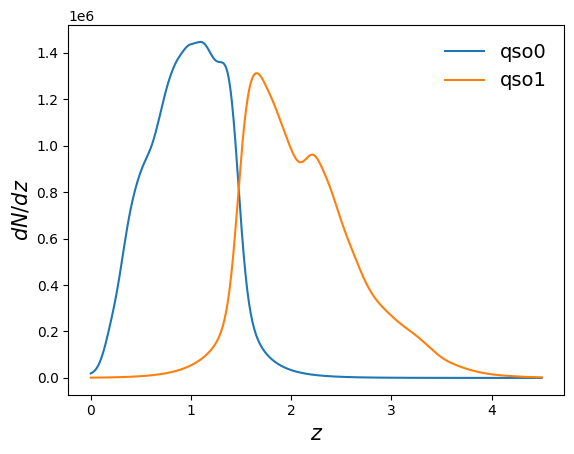

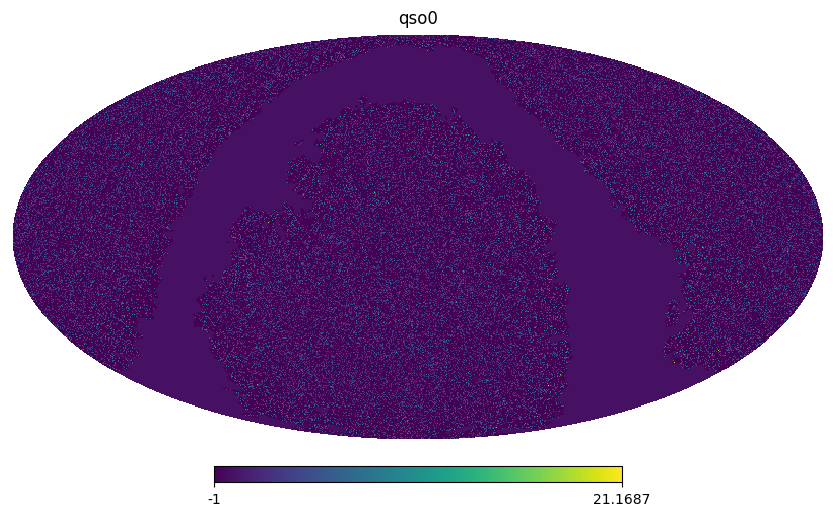

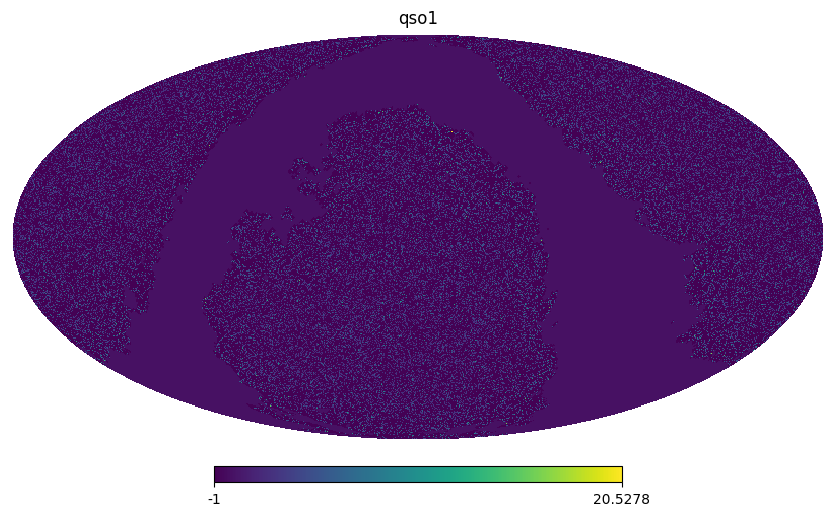

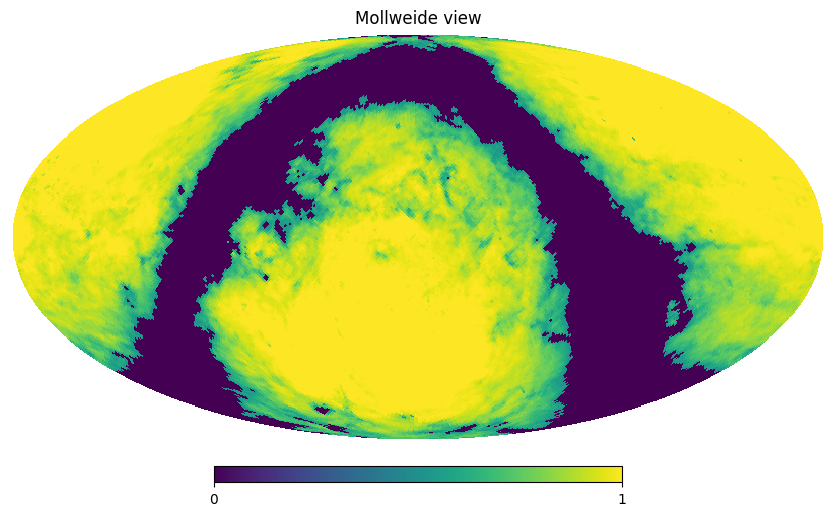

In [3]:
maps = {}
masks = {}
nzs = {}
fgs = {}
pnls = {}

for i in range(nbins):
    print(i+1)
    if nbins == 1:
        selname = f"{predir}GAIA/selection_function_NSIDE64_G{magcut}.fits"
    else:
        # Fixme: we need the selection function for G20.0
        selname = f"{predir}GAIA/selection_function_NSIDE64_G20.5_zsplit{nbins}bin{i}.fits"
    nm = f'qso{i}'
    config = {'nside': nside, 'num_z_bins': num_z_bins, 'z_edges': [z_edges[i], z_edges[i+1]],
              'data_catalog': f"{predir}GAIA/catalog_G{magcut}.fits",
              'selection': selname,
              'mask_threshold': 0.5, 'coords': 'C', 'nz_spec': nz_spec}
    mp = xcl.mappers.MapperGAIAQSO(config)
    maps[nm] = mp.get_signal_map()
    masks[nm] = mp.get_mask()
    nzs[nm] = mp.get_nz()
    pnls[nm] = mp.get_nl_coupled()
    fg = mp.get_nmt_field()
    fg.sel = 'gal'
    fgs[nm] = fg

# Plot stuff
plt.figure()
for nm, dndz in nzs.items():
    z, nz = dndz
    plt.plot(z, nz, label=nm)
plt.xlabel('$z$', fontsize=15)
plt.ylabel('$dN/dz$', fontsize=15)
plt.legend(loc='upper right', fontsize=14, frameon=False)

for n, d in maps.items():
    hp.mollview(d[0], title=n)
mask = masks['qso0']
hp.mollview(mask)

## 3 Prepare lensing map
- Read alms and rotate to Equatorial coordinates.
- Truncate to target resolution.
- Transform to map.
- Read mask and rotate to Equatorial coordinates.
- Apodize (0.2 degrees, C1).
- Binarize and downgrade to target resolution.
- Save all to file to avoid recomputing (since these operations are always the same).
- Read and interpolate Planck transfer function

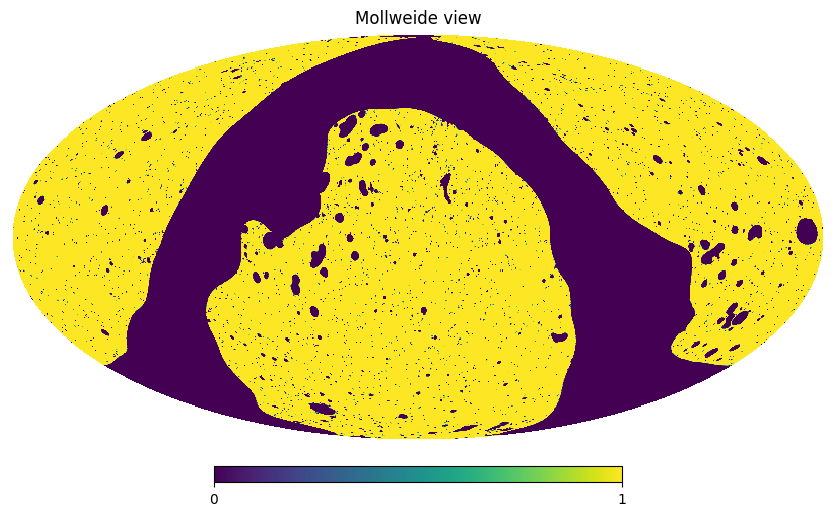

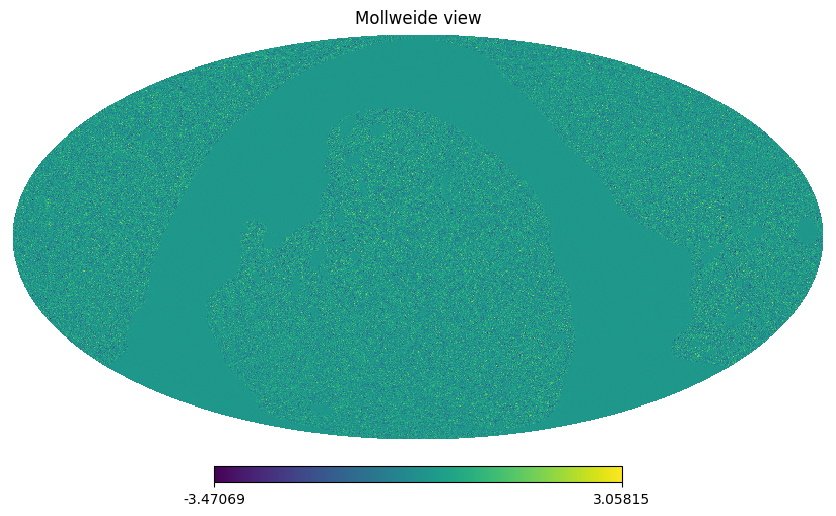

In [4]:
fname = f"kappa_ns{nside}_rotated.fits"
if os.path.isfile(fname):
    kappa = hp.read_map(fname)
else:
    # Read alms
    klm, lmax = hp.read_alm("/home/damonge/Science/Datasets/Planck/Lensing2018/MV/dat_klm.fits",
                            return_mmax=True)
    # Rotate alms
    rot = hp.Rotator(coord=['G', 'C'])
    klm = rot.rotate_alm(klm)
    # Truncate alms
    fl = np.ones(lmax+1)
    fl[3*nside:] = 0
    klm = hp.almxfl(klm, fl, inplace=True)
    # Transform to map
    kappa = hp.alm2map(klm, nside)
    hp.write_map(fname, kappa)

fname = f"mask_kappa_ns{nside}_rotated.fits"
if os.path.isfile(fname):
    msk_k = hp.read_map(fname)
else:
    # Read
    msk_k = hp.read_map("/home/damonge/Science/Datasets/Planck/Lensing2018/mask.fits.gz")
    # Rotate
    msk_k = rot.rotate_map_pixel(msk_k)
    # Apodize
    msk_k = nmt.mask_apodization(msk_k, 0.2, 'C1')
    # Binarize and downgrade
    msk_k[msk_k > 0.5] = 1
    msk_k[msk_k <= 0.5] = 0
    msk_k = hp.ud_grade(msk_k, nside_out=nside)
    # Save
    hp.write_map(fname, msk_k)

hp.mollview(msk_k)
hp.mollview(kappa)

fk = nmt.NmtField(msk_k, [kappa], n_iter=0)
fk.sel = 'kap'
masks['kappa'] = msk_k
maps['kappa'] = kappa
fgs['kappa'] = fk

# Transfer function
d = np.loadtxt("mc_correction_selfunc_masks.dat", unpack=True)
gk_transfer = interp1d(d[0], d[1], bounds_error=False, fill_value=(d[1][0], d[1][-1]))

## 4 Prepare contaminant maps
- Read dust, stars, and M10 maps (stars currently from my own file).
- Subtract mean within quasar mask for all of them
- Read MCs map. Subtract local mean.

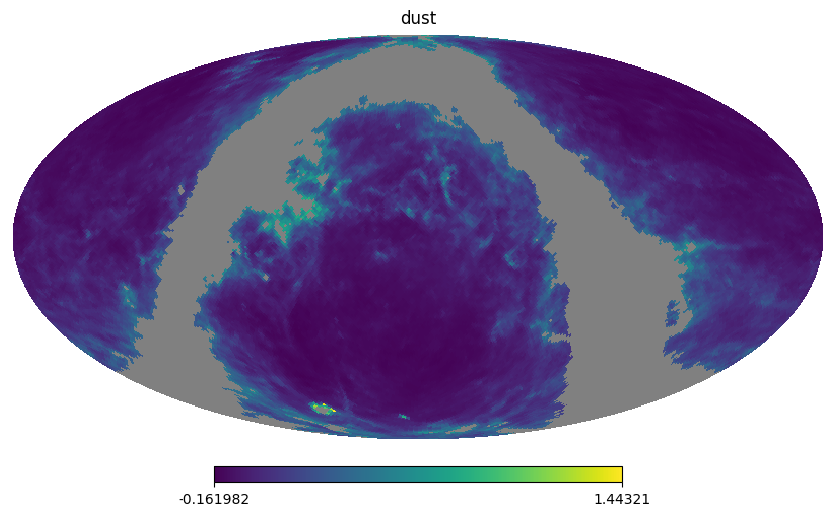

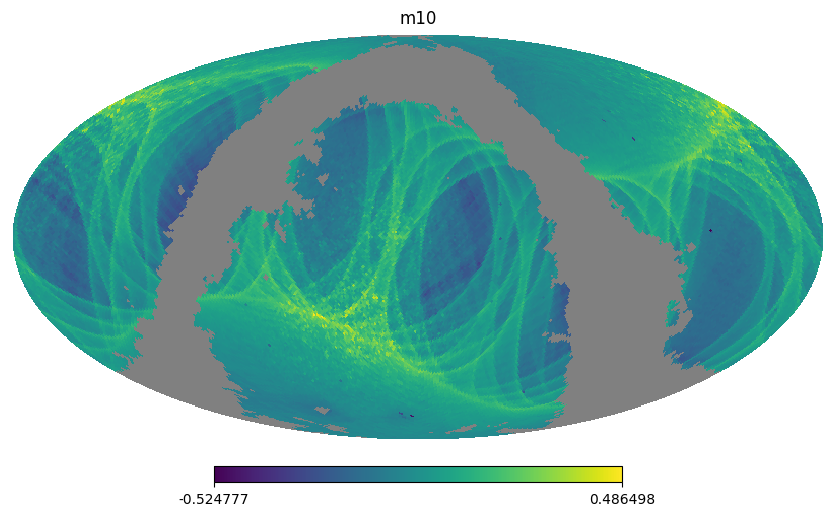

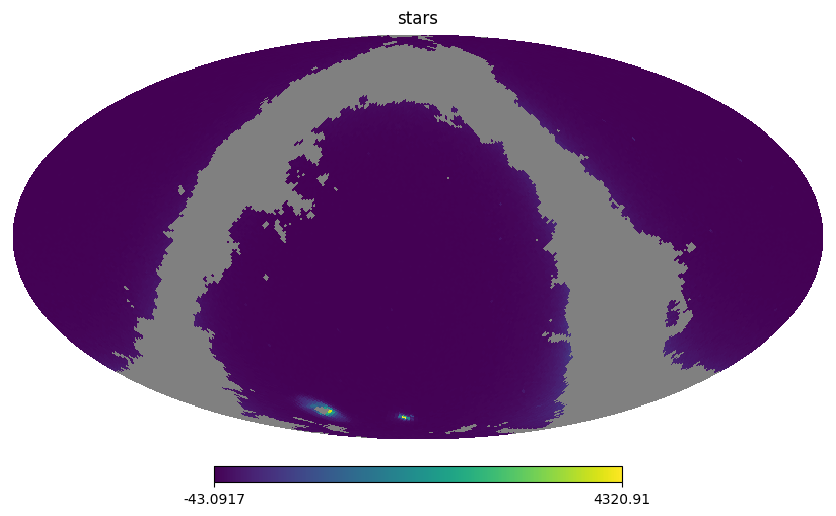

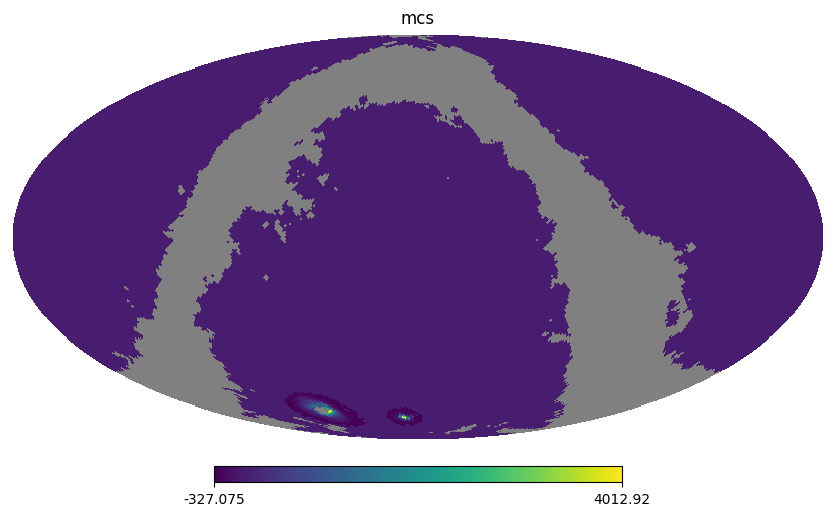

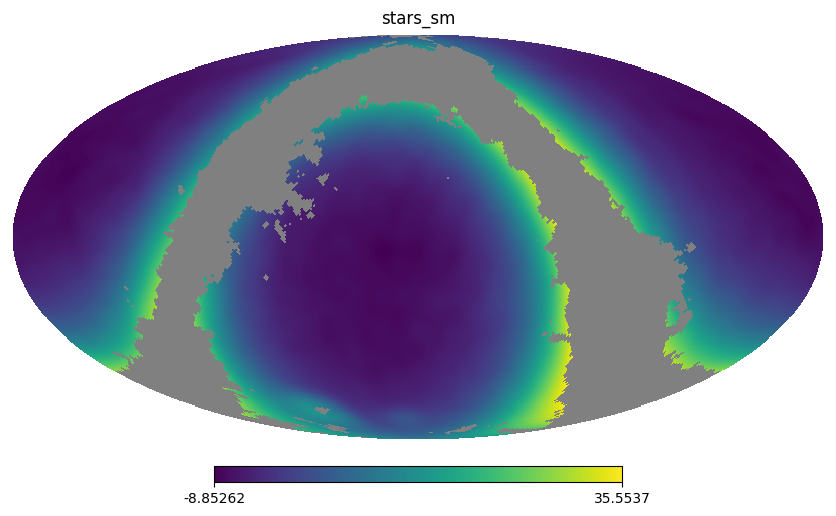

In [5]:
def prepare_sysmap(mp):
    mean = np.sum(mp*mask)/np.sum(mask)
    mp_out = mp-mean
    mp_out[mask <= 0] = 0
    return mp_out


sysmaps = {}
for sys in ['dust', 'm10', 'stars']:
    sysmaps[sys] = prepare_sysmap(hp.ud_grade(np.load("/home/damonge/Science/Datasets/"
                                                      f"GAIA/map_{sys}_NSIDE64.npy"),
                                              nside_out=nside))
# For MCs, subtract only local mean
mcs = hp.ud_grade(np.load("/home/damonge/Science/Datasets/"
                          "GAIA/map_mcs_NSIDE64.npy"),
                  nside_out=nside)
bmask = (mask > 0) & (mcs > 0)
mean = np.mean(mcs[bmask])
mcs = bmask*(mcs-mean)
sysmaps['mcs'] = mcs

sysmaps['stars_sm'] = prepare_sysmap(
    hp.ud_grade(hp.read_map("/home/damonge/Science/Datasets/"
                            "2MPZ_WIxSC/allwise_total_rot_1024.fits"),
                nside_out=nside))

sysnames = list(sysmaps.keys())

for sys in sysnames:
    mp = sysmaps[sys].copy()
    mp[mask <= 0] = hp.UNSEEN
    hp.mollview(mp, title=sys)    

Generate also systematic-deprojected fields

In [6]:
fgs_dp = {}
for i in range(nbins):
    nm = f'qso{i}'
    d = maps[nm]
    m = masks[nm]
    fg = nmt.NmtField(m, d, n_iter=0,
                      templates=[[sys] for _, sys in sysmaps.items()])
    fg.sel = 'gal'
    fgs_dp[nm] = fg
fgs_dp['kappa'] = fk

## 5 Compute power spectra
Write generic calculator computing power spectrum, mode-coupling matrix, noise bias, and bandpower window functions

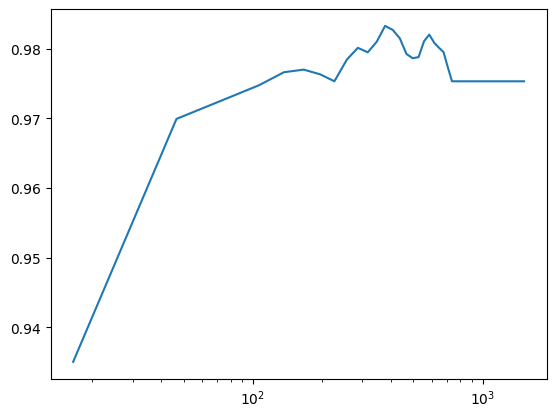

In [7]:
# Bins
b = nmt.NmtBin(nside, nlb=30)
leff = b.get_effective_ells()
t_gk = gk_transfer(leff)
plt.plot(leff, t_gk)
plt.xscale('log')

# Calculator
def get_cl(f1, f2, pnl=None):
    pcl = nmt.compute_coupled_cell(f1, f2)
    w = nmt.NmtWorkspace()
    w.compute_coupling_matrix(f1, f2, b)
    cl = w.decouple_cell(pcl)
    if pnl is not None:
        nl = w.decouple_cell(pnl)
        cl -= nl
    else:
        nl = np.zeros_like(cl)
    wins = w.get_bandpower_windows()
    return cl, nl, w, wins.squeeze()

$C_\ell$ iterator. This is the order in which power spectra will be calculated and stored.

In [8]:
map_names = list(fgs.keys())

def cl_iter():
    icl = 0
    for i1, nm1 in enumerate(map_names):
        for i2, nm2 in enumerate(map_names):
            # Skip repeated
            if i2 < i1:
                continue
            # Skip kappa-kappa
            if (nm1 == 'kappa') and (nm2 == 'kappa'):
                continue
            cl_name = f'{nm1}_{nm2}'
            yield icl, i1, i2, nm1, nm2, cl_name
            icl += 1

Calculate all relevant $C_\ell$s.

Two copies: one for raw maps, and another one for maps after systematics deprojection.

In [9]:
cls = {}
for icl, _, _, nm1, nm2, cl_name in cl_iter():
    print(cl_name)
    fg1 = fgs[nm1]
    fg2 = fgs[nm2]
    pnl = pnls[nm1] if nm1 == nm2 else None
    cl, nl, w, Bbl = get_cl(fg1, fg2, pnl=pnl)
    if 'kappa' in [nm1, nm2]:
        cl /= t_gk
    cls[cl_name] = {'cl': cl, 'nl': nl, 'Bbl': Bbl, 'w': w}

# Deprojected
cls_dp = {}
for icl, _, _, nm1, nm2, cl_name in cl_iter():
    print(cl_name)
    fg1 = fgs_dp[nm1]
    fg2 = fgs_dp[nm2]
    pnl = pnls[nm1] if nm1 == nm2 else None
    cl, nl, w, Bbl = get_cl(fg1, fg2, pnl=pnl)
    if 'kappa' in [nm1, nm2]:
        cl /= t_gk
    cls_dp[cl_name] = {'cl': cl, 'nl': nl, 'Bbl': Bbl, 'w': w}

qso0_qso0
qso0_qso1
qso0_kappa
qso1_qso1
qso1_kappa
qso0_qso0
qso0_qso1
qso0_kappa
qso1_qso1
qso1_kappa


## 6 Calculate covariances
First write generic covariance calculator which stores precomputed covariance workspaces.

In [10]:
cws = {}

def get_cov(f1, f2, f3, f4, w12, w34):
    nm = f'{f1.sel}-{f2.sel}-{f3.sel}-{f4.sel}'
    fs = [f1, f2, f3, f4]
    ms = [f.get_mask() for f in fs]
    cls = np.array([[nmt.compute_coupled_cell(fs[i], fs[j])/np.mean(ms[i]*ms[j])
                     for i in range(4)] for j in range(4)])
    if nm in cws:
        print(f"found {nm}")
        cw = cws[nm]
    else:
        cw = nmt.NmtCovarianceWorkspace()
        cw.compute_coupling_coefficients(f1, f2, f3, f4)
        cws[nm] = cw
    cv = nmt.gaussian_covariance(cw, 0, 0, 0, 0, cls[0, 2], cls[0, 3], cls[1, 2], cls[1, 3], w12, wb=w34)
    return cv

In [11]:
n_cls = nbins*(nbins+3)//2
n_ell = len(cls['qso0_qso0']['cl'][0])

Covariance without deprojection 

In [12]:
cov = []
for i1, _, _, _, _, _ in cl_iter():
    cov.append([])
    for i2, _, _, _, _, _ in cl_iter():
        cov[i1].append(np.zeros([n_ell, n_ell]))

for icl1, _, _, nm1, nm2, cl_name12 in cl_iter():
    f1 = fgs[nm1]
    f2 = fgs[nm2]
    w12 = cls[cl_name12]['w']
    for icl2, _, _, nm3, nm4, cl_name34 in cl_iter():
        print(nm1, nm2, nm3, nm4)
        f3 = fgs[nm3]
        f4 = fgs[nm4]
        w34 = cls[cl_name34]['w']
        if icl2 < icl1:
            cv = cov[icl2][icl1].T
        else:
            cv = get_cov(f1, f2, f3, f4, w12, w34)
        if icl1 == icl2:
            # gg-gg auto cov. Deproject shot noise.
            if (nm1 == nm2) and (Asn_prior is not None):
                nl = cls[cl_name12]['nl'].squeeze()
                cv += Asn_prior**2*np.outer(nl, nl)
            cls[cl_name12]['cov'] = cv
        cov[icl1][icl2] = cv
cov_blocks = np.array(cov)
cov_all = np.transpose(cov_blocks, axes=[0, 2, 1, 3]).reshape([n_cls*n_ell, n_cls*n_ell])

qso0 qso0 qso0 qso0
qso0 qso0 qso0 qso1
found gal-gal-gal-gal
qso0 qso0 qso0 kappa
qso0 qso0 qso1 qso1
found gal-gal-gal-gal
qso0 qso0 qso1 kappa
found gal-gal-gal-kap
qso0 qso1 qso0 qso0
qso0 qso1 qso0 qso1
found gal-gal-gal-gal
qso0 qso1 qso0 kappa
found gal-gal-gal-kap
qso0 qso1 qso1 qso1
found gal-gal-gal-gal
qso0 qso1 qso1 kappa
found gal-gal-gal-kap
qso0 kappa qso0 qso0
qso0 kappa qso0 qso1
qso0 kappa qso0 kappa
qso0 kappa qso1 qso1
qso0 kappa qso1 kappa
found gal-kap-gal-kap
qso1 qso1 qso0 qso0
qso1 qso1 qso0 qso1
qso1 qso1 qso0 kappa
qso1 qso1 qso1 qso1
found gal-gal-gal-gal
qso1 qso1 qso1 kappa
found gal-gal-gal-kap
qso1 kappa qso0 qso0
qso1 kappa qso0 qso1
qso1 kappa qso0 kappa
qso1 kappa qso1 qso1
qso1 kappa qso1 kappa
found gal-kap-gal-kap


With deprojection

In [13]:
cov = []
for i1, _, _, _, _, _ in cl_iter():
    cov.append([])
    for i2, _, _, _, _, _ in cl_iter():
        cov[i1].append(np.zeros([n_ell, n_ell]))

for icl1, _, _, nm1, nm2, cl_name12 in cl_iter():
    f1 = fgs_dp[nm1]
    f2 = fgs_dp[nm2]
    w12 = cls_dp[cl_name12]['w']
    for icl2, _, _, nm3, nm4, cl_name34 in cl_iter():
        print(nm1, nm2, nm3, nm4)
        f3 = fgs_dp[nm3]
        f4 = fgs_dp[nm4]
        w34 = cls_dp[cl_name34]['w']
        if icl2 < icl1:
            cv = cov[icl2][icl1].T
        else:
            cv = get_cov(f1, f2, f3, f4, w12, w34)
        cov[icl1][icl2] = cv
        if icl1 == icl2:
            # gg-gg auto cov. Deproject shot noise.
            if (nm1 == nm2) and (Asn_prior is not None):
                nl = cls_dp[cl_name12]['nl'].squeeze()
                cv += Asn_prior**2*np.outer(nl, nl)
            cls_dp[cl_name12]['cov'] = cv
cov_blocks_dp = np.array(cov)
cov_all_dp = np.transpose(cov_blocks_dp, axes=[0, 2, 1, 3]).reshape([n_cls*n_ell, n_cls*n_ell])

qso0 qso0 qso0 qso0
found gal-gal-gal-gal
qso0 qso0 qso0 qso1
found gal-gal-gal-gal
qso0 qso0 qso0 kappa
found gal-gal-gal-kap
qso0 qso0 qso1 qso1
found gal-gal-gal-gal
qso0 qso0 qso1 kappa
found gal-gal-gal-kap
qso0 qso1 qso0 qso0
qso0 qso1 qso0 qso1
found gal-gal-gal-gal
qso0 qso1 qso0 kappa
found gal-gal-gal-kap
qso0 qso1 qso1 qso1
found gal-gal-gal-gal
qso0 qso1 qso1 kappa
found gal-gal-gal-kap
qso0 kappa qso0 qso0
qso0 kappa qso0 qso1
qso0 kappa qso0 kappa
found gal-kap-gal-kap
qso0 kappa qso1 qso1
found gal-kap-gal-gal
qso0 kappa qso1 kappa
found gal-kap-gal-kap
qso1 qso1 qso0 qso0
qso1 qso1 qso0 qso1
qso1 qso1 qso0 kappa
qso1 qso1 qso1 qso1
found gal-gal-gal-gal
qso1 qso1 qso1 kappa
found gal-gal-gal-kap
qso1 kappa qso0 qso0
qso1 kappa qso0 qso1
qso1 kappa qso0 kappa
qso1 kappa qso1 qso1
qso1 kappa qso1 kappa
found gal-kap-gal-kap


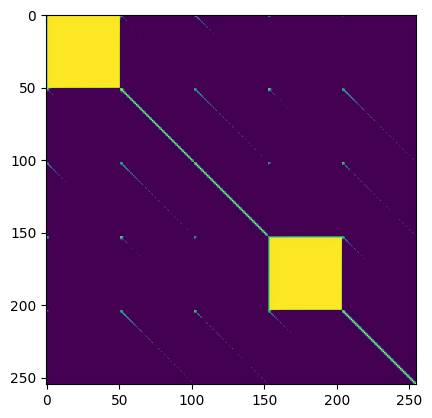

In [14]:
plt.figure()
plt.imshow(np.log10(np.fabs(cov_all/np.sqrt(np.outer(np.diag(cov_all), np.diag(cov_all))))), vmin=-3)

Plot stuff

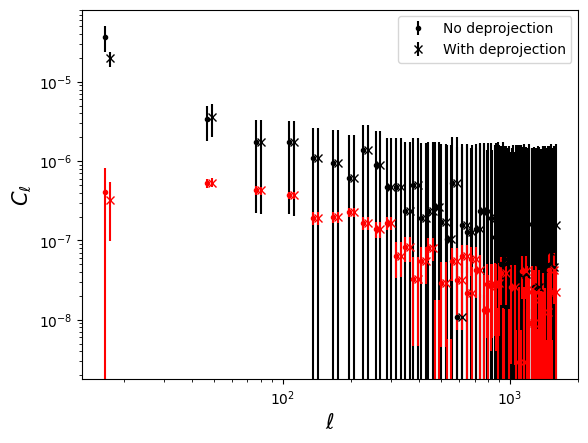

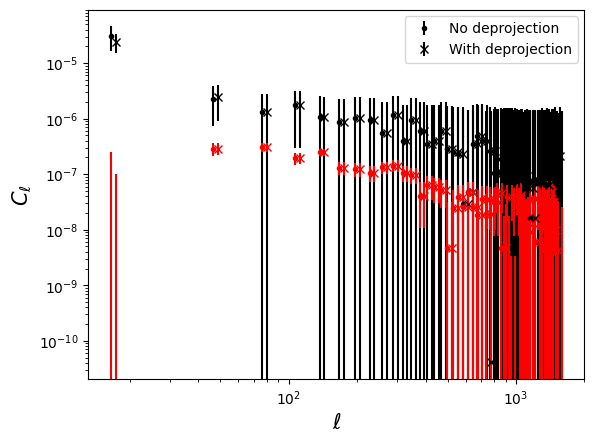

In [15]:
for i in range(nbins):
    plt.figure()
    d = cls[f'qso{i}_qso{i}']
    plt.errorbar(leff, d['cl'][0], yerr=np.sqrt(np.diag(d['cov'])), fmt='k.', label='No deprojection')
    d = cls_dp[f'qso{i}_qso{i}']
    plt.errorbar(leff*1.05, d['cl'][0], yerr=np.sqrt(np.diag(d['cov'])), fmt='kx', label='With deprojection')
    d = cls[f'qso{i}_kappa']
    plt.errorbar(leff, d['cl'][0], yerr=np.sqrt(np.diag(d['cov'])), fmt='r.')
    d = cls_dp[f'qso{i}_kappa']
    plt.errorbar(leff*1.05, d['cl'][0], yerr=np.sqrt(np.diag(d['cov'])), fmt='rx')
    plt.loglog()
    plt.xlabel(r'$\ell$', fontsize=15)
    plt.ylabel(r'$C_\ell$', fontsize=15)
    plt.legend()

## 7 Save sacc files

In [16]:
s = sacc.Sacc()
ls = np.arange(3*nside)
bm = np.ones(3*nside)
for nm in map_names[:-1]:
    zz, nz = nzs[nm]
    s.add_tracer('NZ', nm, quantity='galaxy_density', spin=0, z=zz, nz=nz)
s.add_tracer('Map', 'kappa', quantity='cmb_convergence', spin=0, ell=ls, beam=bm)
for icl1, _, _, nm1, nm2, cl_name in cl_iter():
    d = cls[cl_name]
    s.add_ell_cl('cl_00', nm1, nm2, leff,
                 d['cl'].squeeze(),
                 window=sacc.BandpowerWindow(ls, d['Bbl'].T))
s.add_covariance(cov_all)
fname = f"cls_g_k_{nbins}bins_G{magcut}{nz_suff}{z_suff}"
if Asn_prior is not None:
    fname += "_Asn%.1lf" % Asn_prior
s.save_fits(fname+".fits", overwrite=True)

In [17]:
s = sacc.Sacc()
ls = np.arange(3*nside)
bm = np.ones(3*nside)
for nm in map_names[:-1]:
    zz, nz = nzs[nm]
    s.add_tracer('NZ', nm, quantity='galaxy_density', spin=0, z=zz, nz=nz)
s.add_tracer('Map', 'kappa', quantity='cmb_convergence', spin=0, ell=ls, beam=bm)
for icl1, _, _, nm1, nm2, cl_name in cl_iter():
    d = cls_dp[cl_name]
    s.add_ell_cl('cl_00', nm1, nm2, leff,
                 d['cl'].squeeze(),
                 window=sacc.BandpowerWindow(ls, d['Bbl'].T))
s.add_covariance(cov_all_dp)
fname = f"cls_g_k_{nbins}bins_G{magcut}{nz_suff}{z_suff}"
if Asn_prior is not None:
    fname += "_Asn%.1lf" % Asn_prior
s.save_fits(fname+"_deproj.fits", overwrite=True)

## 8 Null tests
Cross-correlations against systematic maps

Get jackknife regions for null test errors

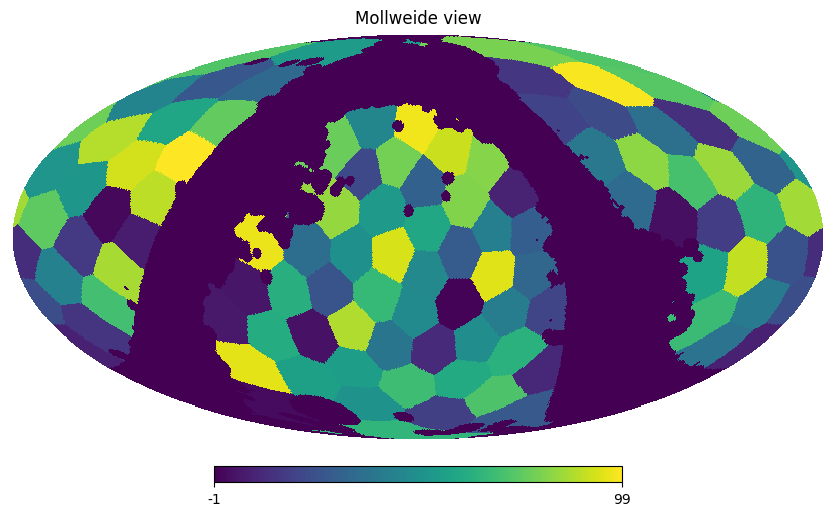

In [18]:
# I calculated these a while ago
d = np.load("jk_regions_100_ns128.npz")
jks = hp.ud_grade(d['jks'], nside_out=nside)
jks[masks['qso0'] == 0] = -1
n_jk = np.amax(jks)+1
hp.mollview(jks)

Null tests with non-deprojected maps

In [19]:
def get_cl_null(dmap, smap, mask):
    fsky = np.mean(mask**2)
    cl = b.bin_cell(hp.anafast(dmap, smap, iter=0))/fsky
    return cl

cls_null = {}
for sysname, sysmap in sysmaps.items():
    cls_null[sysname] = {}
    for i in range(nbins):
        dname = f'qso{i}'
        # Already multiplied by mask
        map_delta = fgs[dname].get_maps()[0]
        mask_full = masks[dname]
        # Multiply systematics map by mask
        smap = sysmap * mask_full
        cl_null = get_cl_null(map_delta, smap, mask_full)
        print(sysname, dname)
        cls_jk = []
        for j in range(n_jk):
            if j % 20 == 0:
                print(j)
            mask_jk = np.ones(hp.nside2npix(nside))
            mask_jk[jks == j] = 0
            cl = get_cl_null(map_delta*mask_jk,
                             smap*mask_jk,
                             mask_full*mask_jk)
            cls_jk.append(cl)
        cls_jk = np.array(cls_jk)
        el_null = np.std(cls_jk, axis=0)*np.sqrt((n_jk-1)**2/n_jk)
        cls_null[sysname][dname] = {'cl': cl_null, 'err': el_null, 'jks': cls_jk}

dust qso0
0
20
40
60
80
dust qso1
0
20
40
60
80
m10 qso0
0
20
40
60
80
m10 qso1
0
20
40
60
80
stars qso0
0
20
40
60
80
stars qso1
0
20
40
60
80
mcs qso0
0
20
40
60
80
mcs qso1
0
20
40
60
80
stars_sm qso0
0
20
40
60
80
stars_sm qso1
0
20
40
60
80


Null tests with deprojected maps

In [20]:
cls_null_dp = {}
for sysname, sysmap in sysmaps.items():
    cls_null_dp[sysname] = {}
    for i in range(nbins):
        dname = f'qso{i}'
        # Already multiplied by mask
        map_delta = fgs_dp[dname].get_maps()[0]
        mask_full = masks[dname]
        # Multiply systematics map by mask
        smap = sysmap * mask_full
        cl_null = get_cl_null(map_delta, smap, mask_full)
        print(sysname, dname)
        cls_jk = []
        for j in range(n_jk):
            if j % 20 == 0:
                print(j)
            mask_jk = np.ones(hp.nside2npix(nside))
            mask_jk[jks == j] = 0
            cl = get_cl_null(map_delta*mask_jk,
                             smap*mask_jk,
                             mask_full*mask_jk)
            cls_jk.append(cl)
        cls_jk = np.array(cls_jk)
        el_null = np.std(cls_jk, axis=0)*np.sqrt((n_jk-1)**2/n_jk)
        cls_null_dp[sysname][dname] = {'cl': cl_null, 'err': el_null, 'jks': cls_jk}

dust qso0
0
20
40
60
80
dust qso1
0
20
40
60
80
m10 qso0
0
20
40
60
80
m10 qso1
0
20
40
60
80
stars qso0
0
20
40
60
80
stars qso1
0
20
40
60
80
mcs qso0
0
20
40
60
80
mcs qso1
0
20
40
60
80
stars_sm qso0
0
20
40
60
80
stars_sm qso1
0
20
40
60
80


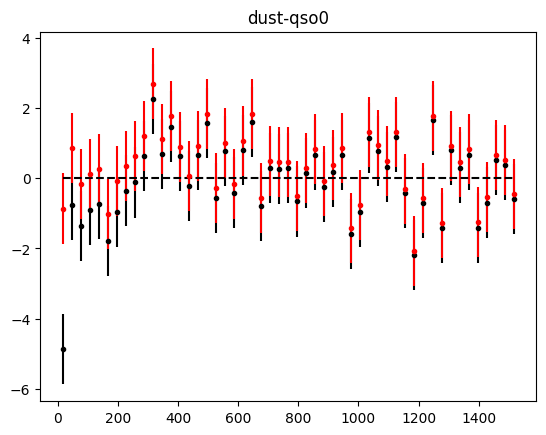

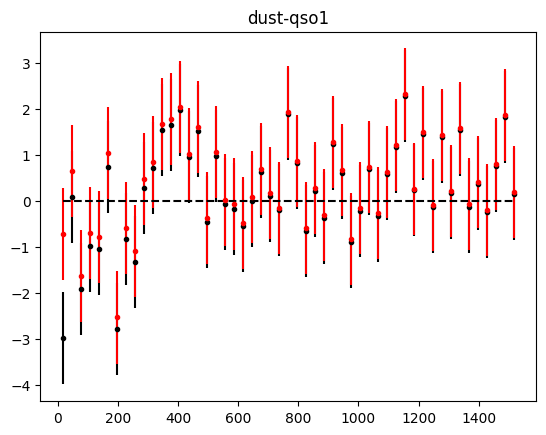

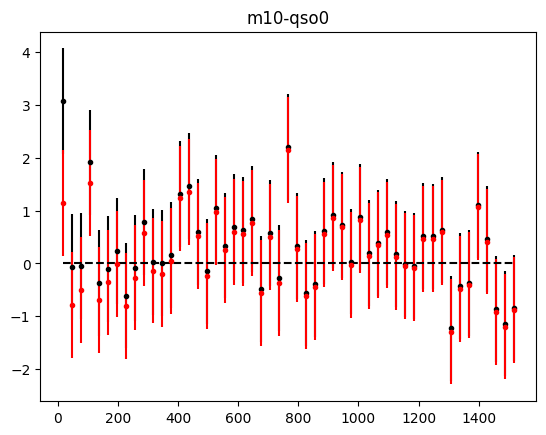

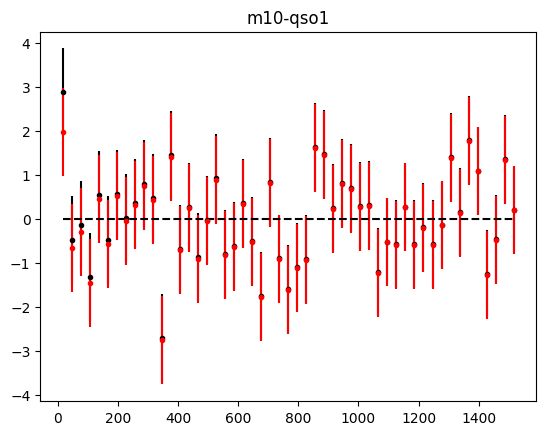

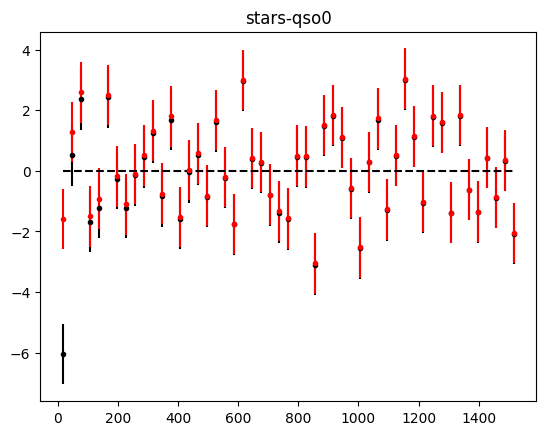

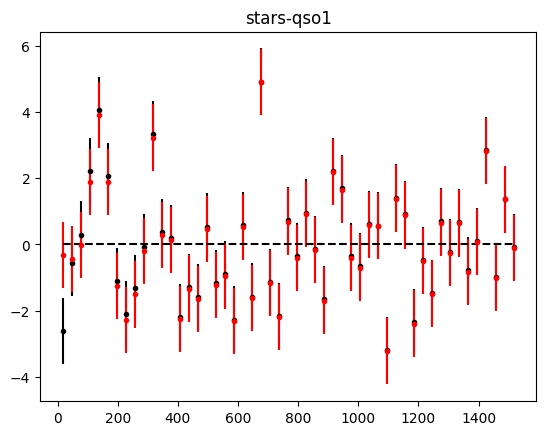

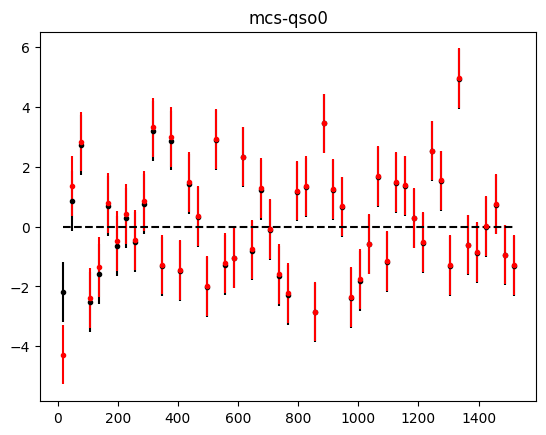

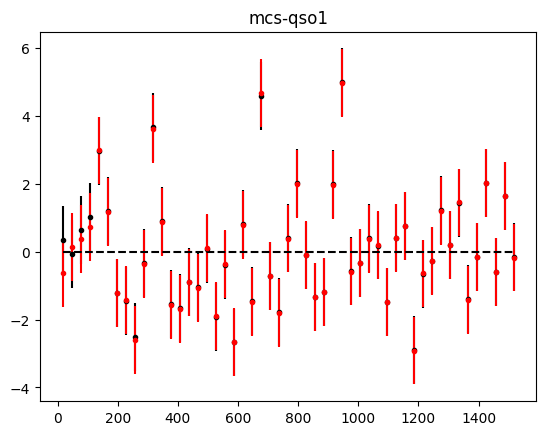

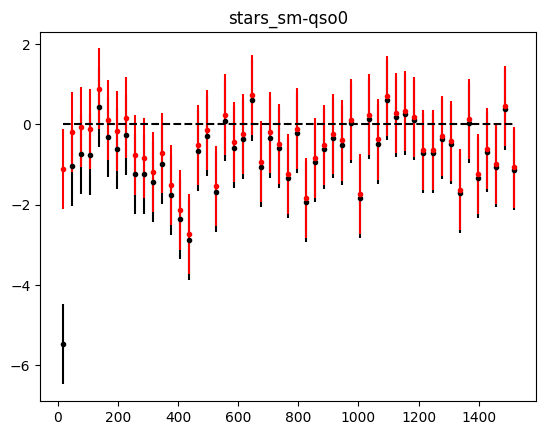

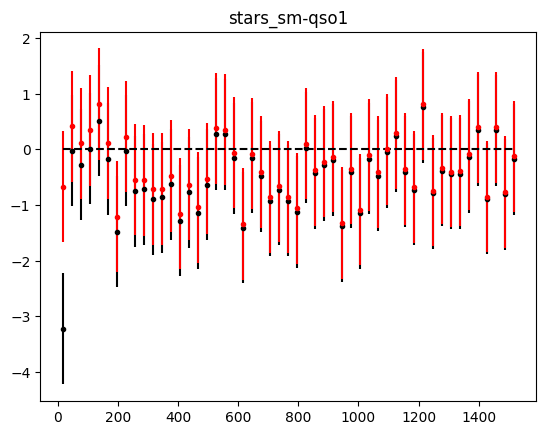

In [21]:
for sname, dd in cls_null.items():
    for dname, d in dd.items():
        plt.figure()
        plt.title(f'{sname}-{dname}')
        plt.errorbar(leff, d['cl']/d['err'], yerr=np.ones_like(leff), fmt='k.')
        dd = cls_null_dp[sname][dname]
        plt.errorbar(leff, dd['cl']/dd['err'], yerr=np.ones_like(leff), fmt='r.')
        plt.plot(leff, np.zeros_like(leff), 'k--')

Save results

In [22]:
s = sacc.Sacc()
ls = np.arange(3*nside)
bm = np.ones(3*nside)
for nm in map_names[:-1]:
    zz, nz = nzs[nm]
    s.add_tracer('NZ', nm, quantity='galaxy_density', spin=0, z=zz, nz=nz)
    s.add_tracer('NZ', nm+'_dp', quantity='galaxy_density', spin=0, z=zz, nz=nz)
for nm in sysnames:
    s.add_tracer('Map', nm, quantity='generic', spin=0, ell=ls, beam=bm)
errs = []
for sname, dd in cls_null.items():
    for dname, d in dd.items():
        s.add_ell_cl('cl_00', dname, sname, leff, d['cl'])
        errs.append(d['err'])
        dd = cls_null_dp[sname][dname]
        s.add_ell_cl('cl_00', dname+'_dp', sname, leff, dd['cl'])
        errs.append(dd['err'])
s.add_covariance(np.diag(np.array(errs).flatten()**2))
s.save_fits(f"cls_null_{nbins}bins_G{magcut}.fits", overwrite=True)